In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pp

from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor

plt.rcParams['figure.figsize'] = [10,10]

In [2]:
train_values = pd.read_csv("data/train_values.csv")
train_labels = pd.read_csv("data/train_labels.csv")
test_values = pd.read_csv("data/test_values.csv")

In [3]:
train_values.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


In [4]:
train_labels.head()

,patient_id,heart_disease_present
0,0z64un,0
1,ryoo3j,0
2,yt1s1x,1
3,l2xjde,1
4,oyt4ek,0


In [32]:
split = len(train_values)/(len(train_values)+len(test_values))
(split, 1-split)

(0.6666666666666666, 0.33333333333333337)

In [33]:
train_labels["heart_disease_present"].mean()

0.4444444444444444

In [34]:
train_values.describe()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,1.550000,131.311111,3.155556,0.694444,0.161111,1.050000,249.211111,1.010000,0.688889,54.811111,149.483333,0.316667
std,0.618838,17.010443,0.938454,0.969347,0.368659,0.998742,52.717969,1.121357,0.464239,9.334737,22.063513,0.466474
min,1.000000,94.000000,1.000000,0.000000,0.000000,0.000000,126.000000,0.000000,0.000000,29.000000,96.000000,0.000000
25%,1.000000,120.000000,3.000000,0.000000,0.000000,0.000000,213.750000,0.000000,0.000000,48.000000,132.000000,0.000000
50%,1.000000,130.000000,3.000000,0.000000,0.000000,2.000000,245.500000,0.800000,1.000000,55.000000,152.000000,0.000000
75%,2.000000,140.000000,4.000000,1.000000,0.000000,2.000000,281.250000,1.600000,1.000000,62.000000,166.250000,1.000000
max,3.000000,180.000000,4.000000,3.000000,1.000000,2.000000,564.000000,6.200000,1.000000,77.000000,202.000000,1.000000


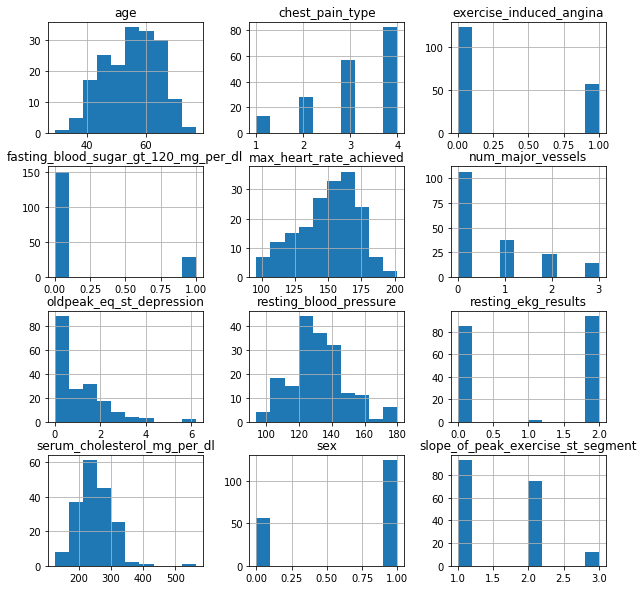

In [35]:
train_values.hist();

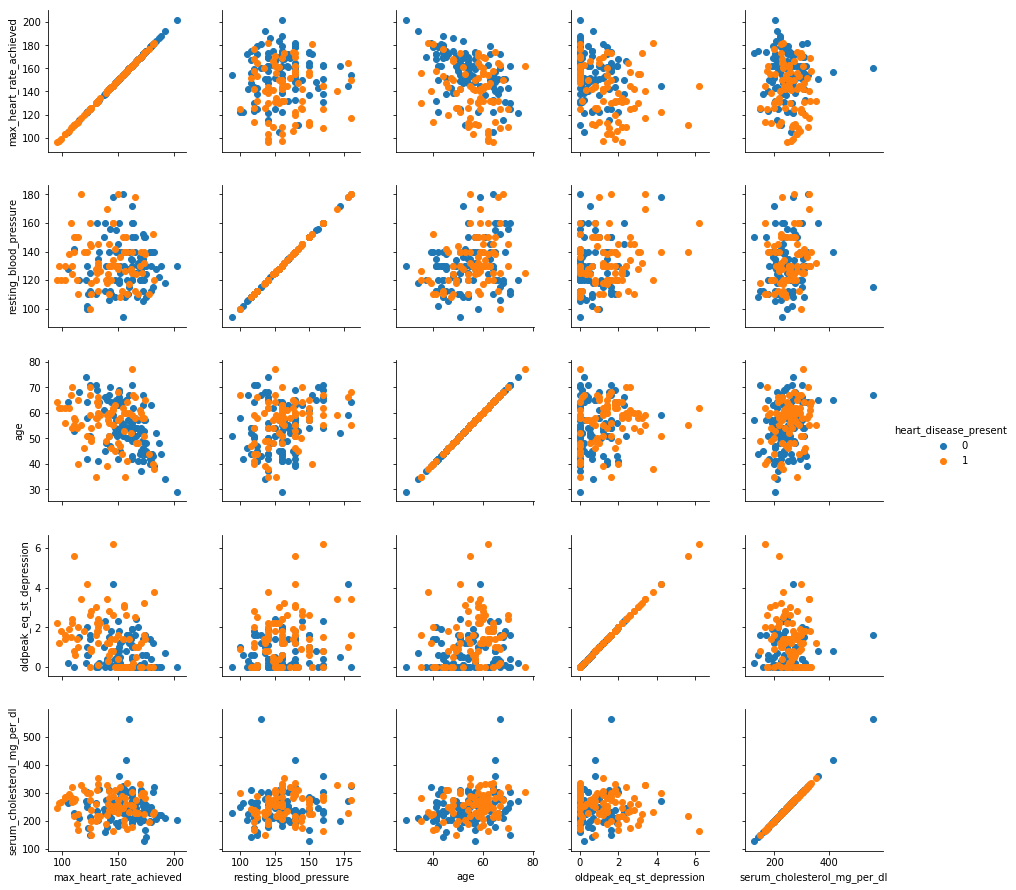

In [7]:
train_with_labels = train_values
train_with_labels["heart_disease_present"] = train_labels["heart_disease_present"] 
g = sns.PairGrid(train_with_labels, hue="heart_disease_present", vars=["max_heart_rate_achieved", "resting_blood_pressure", "age", "oldpeak_eq_st_depression", "serum_cholesterol_mg_per_dl"])
g.map(plt.scatter);
g.add_legend();

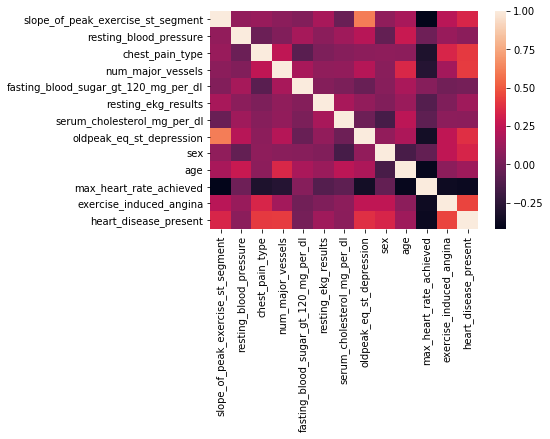

In [8]:
corr = train_with_labels.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [9]:
# One hot encode thal
def one_hot_encode(data, column):
    one_hot = pd.get_dummies(data[column])
    data = data.drop(column,axis = 1)
    data = data.join(one_hot)
    return data

train_values_ohc = one_hot_encode(train_values, 'thal')
train_values_ohc.head()

,patient_id,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present,fixed_defect,normal,reversible_defect
0,0z64un,1,128,2,0,0,2,308,0.0,1,45,170,0,0,0,1,0
1,ryoo3j,2,110,3,0,0,0,214,1.6,0,54,158,0,0,0,1,0
2,yt1s1x,1,125,4,3,0,2,304,0.0,1,77,162,1,1,0,1,0
3,l2xjde,1,152,4,0,0,0,223,0.0,1,40,181,0,1,0,0,1
4,oyt4ek,3,178,1,0,0,2,270,4.2,1,59,145,0,0,0,0,1


In [10]:
train_features = train_values_ohc.drop("patient_id", axis=1)

rf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=15, criterion='gini', n_jobs=-1, oob_score=True, random_state=42)
rf.fit(train_features, train_with_labels["heart_disease_present"]) 
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_features.columns, columns=['importance']).sort_values('importance',ascending=False)

In [11]:
feature_importances

,importance
heart_disease_present,0.372066
reversible_defect,0.122264
normal,0.113540
chest_pain_type,0.110726
num_major_vessels,0.055190
exercise_induced_angina,0.052900
oldpeak_eq_st_depression,0.043949
max_heart_rate_achieved,0.039595
slope_of_peak_exercise_st_segment,0.028389
age,0.021914


In [12]:
train_features = train_features.drop("heart_disease_present", axis=1)

In [13]:
rf_entropy = RandomForestClassifier(n_estimators=1000, min_samples_leaf=15, criterion='entropy', n_jobs=-1, oob_score=True, random_state=42)
rf_entropy.fit(train_features, train_labels["heart_disease_present"]) 
feature_importances = pd.DataFrame(rf_entropy.feature_importances_, index = train_features.columns, columns=['importance']).sort_values('importance',ascending=False)

In [14]:
feature_importances

,importance
reversible_defect,0.156403
chest_pain_type,0.148675
normal,0.146892
exercise_induced_angina,0.094976
num_major_vessels,0.088300
max_heart_rate_achieved,0.079792
oldpeak_eq_st_depression,0.076892
slope_of_peak_exercise_st_segment,0.051136
age,0.050071
sex,0.040519


In [15]:
test_values.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,olalu7,2,reversible_defect,170,1,0,0,2,288,0.2,1,59,159,0
1,z9n6mx,1,normal,138,4,0,0,0,183,1.4,0,35,182,0
2,5k4413,2,reversible_defect,120,4,0,0,2,177,2.5,1,43,120,1
3,mrg7q5,1,normal,102,3,1,0,0,318,0.0,0,60,160,0
4,uki4do,2,normal,138,4,1,0,2,166,3.6,1,61,125,1


# RANDOM FORESTS

In [53]:
# for scoring the rf's 
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels["heart_disease_present"], test_size=0.33, random_state=42)

In [62]:
rf_gini_scorer = RandomForestClassifier(n_estimators=1000, min_samples_leaf=3, criterion='gini', n_jobs=-1, oob_score=True, random_state=42);
rf_entropy_scorer = RandomForestClassifier(n_estimators=1000, min_samples_leaf=3, criterion='entropy', n_jobs=-1, oob_score=True, random_state=42);

In [68]:
scores = cross_val_score(rf_gini_scorer, train_features, train_labels["heart_disease_present"], cv=10)
scores.mean()

0.8277777777777777

In [65]:
scores = cross_val_score(rf_entropy_scorer, train_features, train_labels["heart_disease_present"], cv=10)
scores.mean()

0.8111111111111111

In [154]:
# i have no idea where to start defining these trees, and am guessing at the model parameters.
# why don't we guess a lot more and see what's best

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pp.pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 16],
 'min_samples_split': [2, 3, 5, 7, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [311]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(train_features, train_labels["heart_disease_present"])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 3, 5, 7, 10], 'min_samples_leaf': [1, 2, 4, 8, 16]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [312]:
rf_random.best_params_

{'n_estimators': 1577,
 'min_samples_split': 3,
 'min_samples_leaf': 8,
 'max_features': 'sqrt',
 'max_depth': 80}

In [70]:
rcv_params = {'n_estimators': 1577,
             'min_samples_split': 3,
             'min_samples_leaf': 8,
             'max_features': 'sqrt',
             'max_depth': 80,
             'oob_score': True}

X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels["heart_disease_present"], test_size=0.2, random_state=42)
rf_rcv_scorer = RandomForestClassifier(**rcv_params)

scores = cross_val_score(rf_rcv_scorer, train_features, train_labels["heart_disease_present"], cv=10)
scores.mean()

0.8166666666666667

In [313]:
param_grid = {
    'max_depth': [10, 20, 30, 60, 70, 80],
    'max_features': ["auto","sqrt"],
    'min_samples_leaf': [4, 5, 6, 7, 8, 9, 10, 11],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1400, 1450, 1500, 1550, 1600, 1650]
}

rf_gs = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator = rf_gs, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 52.8min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 61.7min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 71.3min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | 

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 1400}

In [71]:
gs1_params = {'max_depth': 10,
             'max_features': 'auto',
             'min_samples_leaf': 7,
             'min_samples_split': 2,
             'n_estimators': 1400,
             'oob_score': True}

rf_gs_scorer = RandomForestClassifier(**gs1_params)
scores = cross_val_score(rf_gs_scorer, train_features, train_labels["heart_disease_present"], cv=10)
scores.mean()

0.8222222222222222

In [315]:
rf_gsr = RandomForestRegressor(**grid_search.best_params_)
rf_gsr.fit(train_features,train_labels["heart_disease_present"])
ms = rf_gsr.predict(one_hot_encode(test_values.drop('patient_id',axis=1), 'thal'))
df_out = test_values[['patient_id']]
df_out['heart_disease_present'] = ms
df_out.to_csv("rf_out_ms.csv", index=False)

c:\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [338]:
best_rf_params = {'max_depth': 80,
                 'max_features': 3,
                 'min_samples_leaf': 3,
                 'min_samples_split': 10,
                 'oob_score': True}

rf_reg = RandomForestClassifier(**best_rf_params, n_estimators=5000);
rf_reg.fit(train_features, train_labels["heart_disease_present"])
scores = cross_val_score(rf_reg, train_features, train_labels["heart_disease_present"], cv=10)
scores.mean()

0.8333333333333333

In [73]:
predictions = rf_reg.predict(one_hot_encode(test_values.drop('patient_id',axis=1), 'thal'))

In [217]:
df_out = test_values[['patient_id']]
df_out['heart_disease_present'] = predictions

c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [218]:
df_out.to_csv("rf_out_ws_oob.csv", index=False)

In [ ]:
"""
    Log loss: 0.36721
"""

In [220]:
param_grid = {
    'max_depth': [75, 77, 80, 83, 85],
    'max_features': [1, 2, 3],
    'min_samples_leaf': [3, 4, 5, 6],
    'min_samples_split': [9, 10, 11],
    'n_estimators': [90, 100, 110, 120, 150]
}

rf_gs = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator = rf_gs, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  2.5min finished


{'max_depth': 75,
 'max_features': 1,
 'min_samples_leaf': 3,
 'min_samples_split': 9,
 'n_estimators': 90}

In [221]:
param_grid = {
    'max_depth': [60, 70, 72, 74, 76],
    'max_features': [1,2,3],
    'min_samples_leaf': [3],
    'min_samples_split': [9],
    'n_estimators': [78, 82, 86, 90, 92, 94]
}

rf_gs = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator = rf_gs, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   23.0s finished


{'max_depth': 60,
 'max_features': 1,
 'min_samples_leaf': 3,
 'min_samples_split': 9,
 'n_estimators': 78}

In [242]:
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_features': [1,2,3,4,5,6],
    'min_samples_leaf': [1,2,3,4,5],
    'min_samples_split': [7,8,9,10,11,12,13],
    'n_estimators': [100,200,500,1000]
}

rf_gs = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator = rf_gs, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 8400 candidates, totalling 25200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

{'max_depth': 6,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 7,
 'n_estimators': 100}

In [251]:
best_params_small = grid_search.best_params_
rf_reg_s = RandomForestRegressor(**best_params_small, bootstrap=True)
rf_reg_s.fit(train_features, train_labels["heart_disease_present"])
predictions_s = rf_reg_s.predict(one_hot_encode(test_values.drop('patient_id',axis=1), 'thal'))

In [252]:
predictions_s

array([0.4635763 , 0.15880791, 0.92211191, 0.1817244 , 0.7657197 ,
       0.00950747, 0.38667439, 0.65189358, 0.31281149, 0.12417842,
       0.26281695, 0.53122932, 0.2922676 , 0.812028  , 0.17328809,
       0.04406217, 0.07849472, 0.16158403, 0.80113477, 0.05695664,
       0.97374055, 0.16173854, 0.17638458, 0.07571001, 0.57063986,
       0.81061709, 0.49835826, 0.19910008, 0.51100656, 0.01196404,
       0.873057  , 0.4222812 , 0.55807739, 0.3701906 , 0.29848467,
       0.14456166, 0.39279323, 0.23971842, 0.37255867, 0.1832529 ,
       0.89892399, 0.24037568, 0.89403139, 0.09900993, 0.85483135,
       0.06371344, 0.13589427, 0.29516725, 0.19887794, 0.54928162,
       0.5139296 , 0.03823186, 0.93012576, 0.15280004, 0.41896076,
       0.05219516, 0.78542172, 0.14346507, 0.15512698, 0.6127864 ,
       0.08970542, 0.86060123, 0.27948959, 0.75174549, 0.25895833,
       0.64045181, 0.63805467, 0.52431255, 0.81309765, 0.55378105,
       0.17669708, 0.94412944, 0.93666299, 0.9276885 , 0.90466

In [253]:
df_out = test_values[['patient_id']]
df_out['heart_disease_present'] = predictions_s
df_out.to_csv("rf_out_s_bootstrapped.csv", index=False)

c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [81]:
best_params_small = {'max_depth': 6,
                     'max_features': 3,
                     'min_samples_leaf': 3,
                     'min_samples_split': 7,
                     'n_estimators': 1000,
                     'oob_score': True}

rf_reg_s = RandomForestClassifier(**best_params_small)
rf_reg_s.fit(X_train, y_train)

scores = cross_val_score(rf_reg_s, train_features, train_labels["heart_disease_present"], cv=10)
scores.mean()

0.8333333333333333

In [247]:
# Without a lot more feature engineering, that's probably the best random forests will perform for now

In [83]:
clf = AdaBoostClassifier(n_estimators=1000, learning_rate=0.00266)
scores = cross_val_score(clf, train_features, train_labels["heart_disease_present"], cv=5)
scores.mean()

0.8166666666666667

In [99]:
# Looking through n_estimators 
best_rf_params = {'max_depth': 6,
                 'max_features': 3,
                 'min_samples_leaf': 3,
                 'min_samples_split': 7,
                 'n_estimators': 5000}

glf = GradientBoostingClassifier(**best_rf_params)
scores = cross_val_score(glf, train_features, train_labels["heart_disease_present"], cv=10)
scores.mean()

0.8166666666666668

# GRADIENT BOOSTING

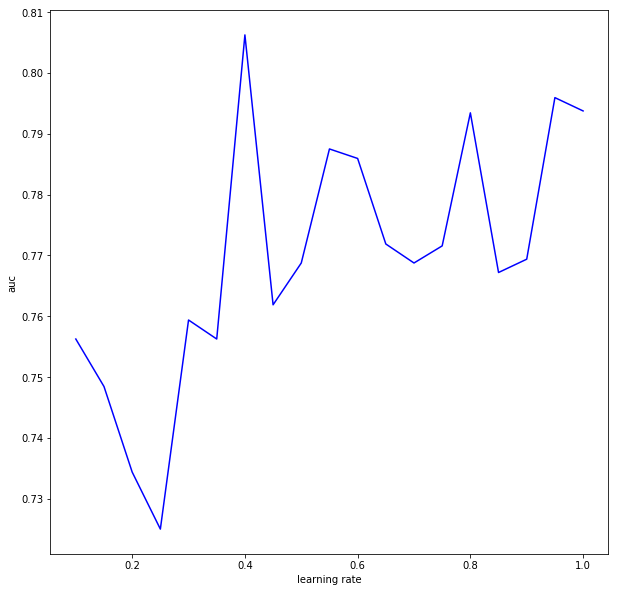

In [130]:
learning_rates = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
score_results = []

for eta in learning_rates:
    model = GradientBoostingClassifier(learning_rate=eta)
    table = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels["heart_disease_present"], test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        table.append(roc_auc)
    score_results.append(np.mean(table))
    
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(learning_rates, score_results, 'b', label="test score")
plt.ylabel('auc')
plt.xlabel('learning rate')
plt.show()

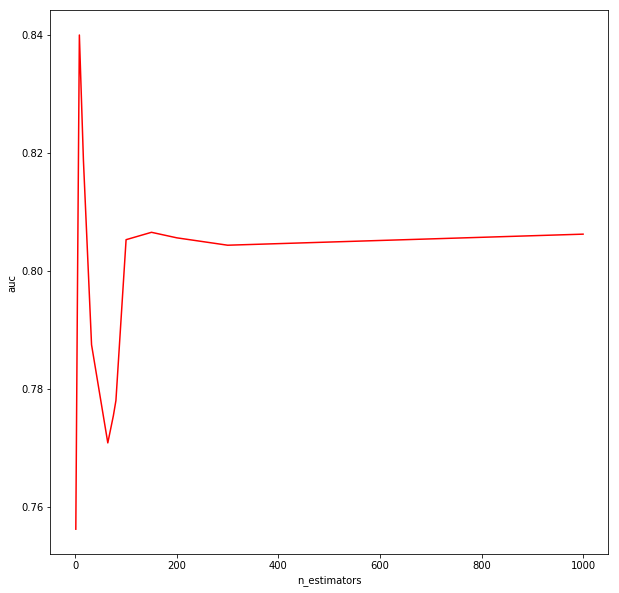

In [306]:
n_estimators = [1, 4, 8, 16, 32, 64, 75, 80, 100, 150, 200, 300, 1000]
test_results = []

for estimator in n_estimators:
    model = GradientBoostingClassifier(learning_rate=0.4, n_estimators=estimator)
    table = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels["heart_disease_present"], test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        table.append(roc_auc)
    test_results.append(np.mean(table))
    
from matplotlib.legend_handler import HandlerLine2D
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.ylabel('auc')
plt.xlabel('n_estimators')
plt.show()

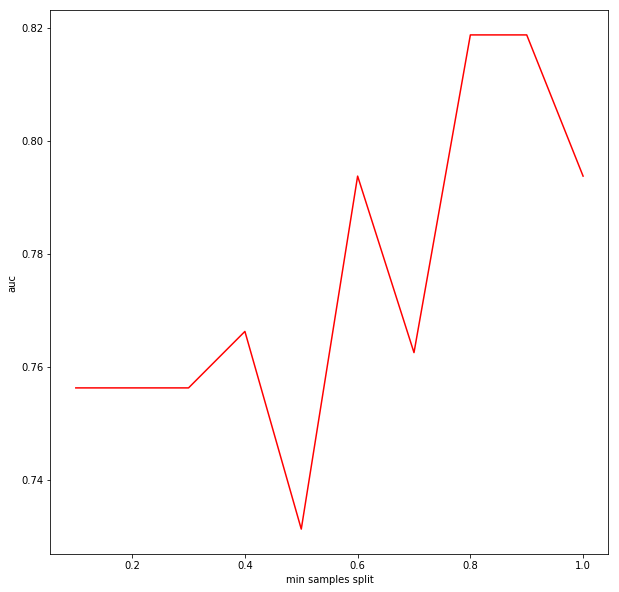

In [307]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
test_results = []

for min_samples_split in min_samples_splits:
    model = GradientBoostingClassifier(learning_rate=0.4, n_estimators=150,min_samples_split=min_samples_split)
    table = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels["heart_disease_present"], test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        table.append(roc_auc)
    test_results.append(np.mean(table))
    
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.ylabel('auc')
plt.xlabel('min samples split')
plt.show()

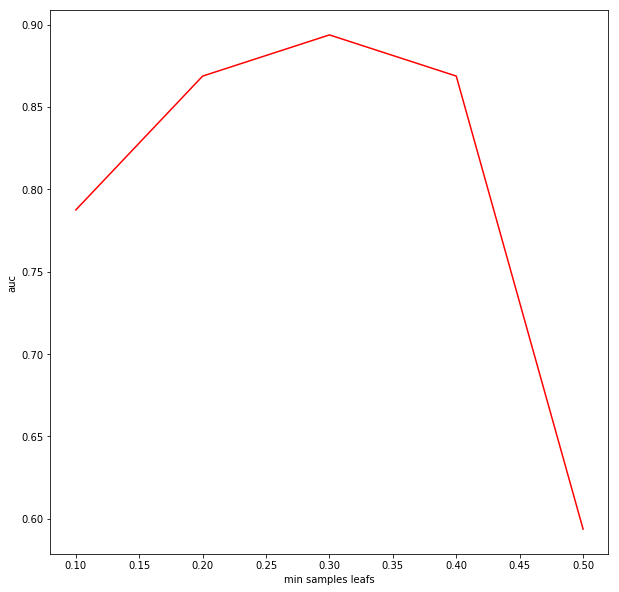

In [308]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
test_results = []
for min_samples_leaf in min_samples_leafs:
    model = GradientBoostingClassifier(learning_rate=0.4, n_estimators=150, min_samples_split=0.9, min_samples_leaf=min_samples_leaf)
    table = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels["heart_disease_present"], test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        table.append(roc_auc)
    test_results.append(np.mean(table))
    
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('auc')
plt.xlabel('min samples leafs')
plt.show()

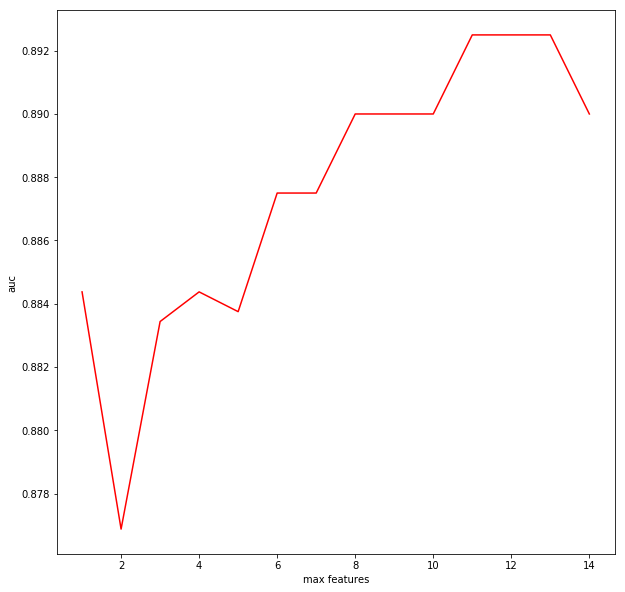

In [309]:
max_features = list(range(1,train_features.shape[1]))
test_results = []

for max_feature in max_features:
    model = GradientBoostingClassifier(learning_rate=0.4, n_estimators=150, min_samples_split=0.9, min_samples_leaf=0.3, max_features=max_feature)
    table = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels["heart_disease_present"], test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        table.append(roc_auc)
    test_results.append(np.mean(table))
    
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('auc')
plt.xlabel('max features')
plt.show()

In [319]:
best_gb_params = {'learning_rate': 0.4,
                 'max_features': 12,
                 'min_samples_leaf': 0.3,
                 'min_samples_split': 0.9}

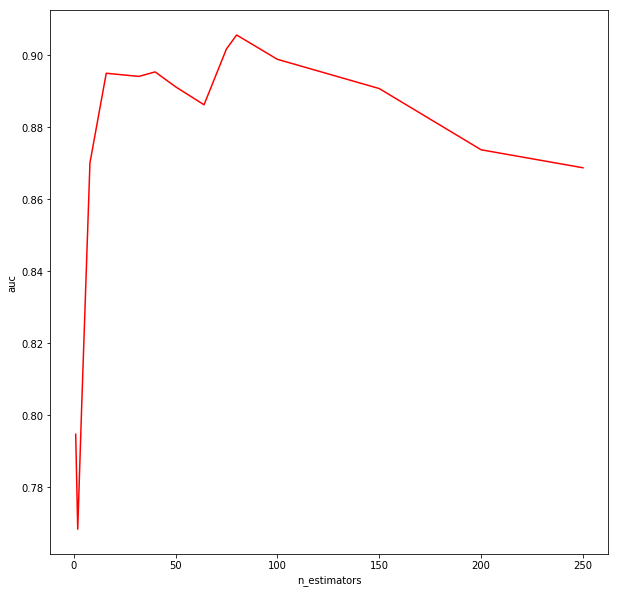

In [320]:
n_estimators = [1, 2, 4, 8, 16, 32, 40, 50, 64, 75, 80, 100, 150, 200, 250]
test_results = []

for estimator in n_estimators:
    model = GradientBoostingClassifier(**best_gb_params, n_estimators=estimator)
    table = []
    for i in range(50):
        X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels["heart_disease_present"], test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        table.append(roc_auc)
    test_results.append(np.mean(table))
    
from matplotlib.legend_handler import HandlerLine2D
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.ylabel('auc')
plt.xlabel('n_estimators')
plt.show()

In [336]:
glf = GradientBoostingClassifier(**best_gb_params, n_estimators=100)
scores = cross_val_score(glf, train_features, train_labels["heart_disease_present"], cv=10)
scores.mean()

0.8111111111111111

In [339]:
scores_cv_all = []
for i in range(20):
    glf = GradientBoostingClassifier(**best_gb_params, n_estimators=100)
    scores = cross_val_score(glf, train_features, train_labels["heart_disease_present"], cv=10)
    scores_cv_all.append(scores.mean())
np.mean(scores_cv_all)

0.8108333333333334

In [301]:
glf_predictions_multigen = []
for i in range(100):
    glf = GradientBoostingRegressor(**best_gb_params, n_estimators=50)
    glf.fit(train_features, train_labels["heart_disease_present"])
    glf_predictions = glf.predict(one_hot_encode(test_values.drop('patient_id',axis=1), 'thal'))
    glf_predictions = abs(glf_predictions)
    glf_predictions_multigen.append(glf_predictions)
    
glf_predictions_multigen = np.mean(glf_predictions_multigen, axis=0)

In [302]:
df_out = test_values[['patient_id']]
df_out['heart_disease_present'] = glf_predictions_multigen
df_out.to_csv("glf_predictions_multigen.csv", index=False)

c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# FEATURE INTERACTION

In [346]:
import itertools
len(list(itertools.combinations(train_features, 2)))

105

In [347]:
training_interactions = pd.DataFrame()

In [349]:
for p1,p2 in list(itertools.combinations(train_features, 2)):
    training_interactions[p1 + "+" + p2] = train_features[p1]*train_features[p2]

In [351]:
training_interactions.head()

,slope_of_peak_exercise_st_segment+resting_blood_pressure,slope_of_peak_exercise_st_segment+chest_pain_type,slope_of_peak_exercise_st_segment+num_major_vessels,slope_of_peak_exercise_st_segment+fasting_blood_sugar_gt_120_mg_per_dl,slope_of_peak_exercise_st_segment+resting_ekg_results,slope_of_peak_exercise_st_segment+serum_cholesterol_mg_per_dl,slope_of_peak_exercise_st_segment+oldpeak_eq_st_depression,slope_of_peak_exercise_st_segment+sex,slope_of_peak_exercise_st_segment+age,slope_of_peak_exercise_st_segment+max_heart_rate_achieved,...,max_heart_rate_achieved+exercise_induced_angina,max_heart_rate_achieved+fixed_defect,max_heart_rate_achieved+normal,max_heart_rate_achieved+reversible_defect,exercise_induced_angina+fixed_defect,exercise_induced_angina+normal,exercise_induced_angina+reversible_defect,fixed_defect+normal,fixed_defect+reversible_defect,normal+reversible_defect
0,128,2,0,0,2,308,0.0,1,45,170,...,0,0,170,0,0,0,0,0,0,0
1,220,6,0,0,0,428,3.2,0,108,316,...,0,0,158,0,0,0,0,0,0,0
2,125,4,3,0,2,304,0.0,1,77,162,...,162,0,162,0,0,1,0,0,0,0
3,152,4,0,0,0,223,0.0,1,40,181,...,0,0,0,181,0,0,0,0,0,0
4,534,3,0,0,6,810,12.6,3,177,435,...,0,0,0,145,0,0,0,0,0,0


In [352]:
rf_entropy = RandomForestClassifier(n_estimators=1000, min_samples_leaf=15, criterion='entropy', n_jobs=-1, oob_score=True, random_state=42)
rf_entropy.fit(training_interactions, train_labels["heart_disease_present"]) 
interaction_importances = pd.DataFrame(rf_entropy.feature_importances_, index = training_interactions.columns, columns=['importance']).sort_values('importance',ascending=False)

In [354]:
interaction_importances[:10]

,importance
max_heart_rate_achieved+normal,0.070681
chest_pain_type+reversible_defect,0.053787
resting_blood_pressure+reversible_defect,0.045316
oldpeak_eq_st_depression+reversible_defect,0.042361
slope_of_peak_exercise_st_segment+reversible_defect,0.034946


In [355]:
train_features_extended = pd.concat([train_features, training_interactions], axis=1, sort=False)

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,...,max_heart_rate_achieved+exercise_induced_angina,max_heart_rate_achieved+fixed_defect,max_heart_rate_achieved+normal,max_heart_rate_achieved+reversible_defect,exercise_induced_angina+fixed_defect,exercise_induced_angina+normal,exercise_induced_angina+reversible_defect,fixed_defect+normal,fixed_defect+reversible_defect,normal+reversible_defect
0,1,128,2,0,0,2,308,0.0,1,45,...,0,0,170,0,0,0,0,0,0,0
1,2,110,3,0,0,0,214,1.6,0,54,...,0,0,158,0,0,0,0,0,0,0
2,1,125,4,3,0,2,304,0.0,1,77,...,162,0,162,0,0,1,0,0,0,0
3,1,152,4,0,0,0,223,0.0,1,40,...,0,0,0,181,0,0,0,0,0,0
4,3,178,1,0,0,2,270,4.2,1,59,...,0,0,0,145,0,0,0,0,0,0


In [360]:
rf_gini_scorer = RandomForestClassifier(n_estimators=1000, min_samples_leaf=3, criterion='gini', n_jobs=-1, oob_score=True, random_state=42);
scores = cross_val_score(rf_gini_scorer, train_features_extended, train_labels["heart_disease_present"], cv=10)
scores.mean()

0.8333333333333334

In [361]:
for p1,p2,p3 in list(itertools.combinations(train_features, 3)):
    training_interactions[p1 + "+" + p2 + "+" + p3] = train_features[p1]*train_features[p2]*train_features[p3]

rf_entropy = RandomForestClassifier(n_estimators=1000, min_samples_leaf=15, criterion='entropy', n_jobs=-1, oob_score=True, random_state=42)
rf_entropy.fit(training_interactions, train_labels["heart_disease_present"]) 
interaction_importances = pd.DataFrame(rf_entropy.feature_importances_, index = training_interactions.columns, columns=['importance']).sort_values('importance',ascending=False)

In [397]:
interaction_importances

,importance
slope_of_peak_exercise_st_segment+chest_pain_type+reversible_defect,0.022242
max_heart_rate_achieved+normal,0.020790
slope_of_peak_exercise_st_segment+chest_pain_type+num_major_vessels,0.018018
chest_pain_type+oldpeak_eq_st_depression+exercise_induced_angina,0.017110
chest_pain_type+oldpeak_eq_st_depression+reversible_defect,0.016209
resting_blood_pressure+chest_pain_type+reversible_defect,0.015119
slope_of_peak_exercise_st_segment+chest_pain_type+serum_cholesterol_mg_per_dl,0.014954
slope_of_peak_exercise_st_segment+resting_blood_pressure+reversible_defect,0.014629
chest_pain_type+serum_cholesterol_mg_per_dl+reversible_defect,0.013632
chest_pain_type+sex+age,0.013078


In [425]:
todrop = list(interaction_importances[interaction_importances.importance < 0.015].index)

In [432]:
for x in todrop:
    if x in training_interactions.columns:
        training_interactions = training_interactions.drop(x,axis=1)


rf_entropy = RandomForestClassifier(n_estimators=1000, min_samples_leaf=15, criterion='entropy', n_jobs=-1, oob_score=True, random_state=42)
rf_entropy.fit(training_interactions, train_labels["heart_disease_present"]) 
interaction_importances_v2 = pd.DataFrame(rf_entropy.feature_importances_, index = training_interactions.columns, columns=['importance']).sort_values('importance',ascending=False)

In [434]:
interaction_importances_v2

,importance
slope_of_peak_exercise_st_segment+chest_pain_type+reversible_defect,0.222227
max_heart_rate_achieved+normal,0.173607
slope_of_peak_exercise_st_segment+chest_pain_type+num_major_vessels,0.172108
chest_pain_type+oldpeak_eq_st_depression+reversible_defect,0.165289
chest_pain_type+oldpeak_eq_st_depression+exercise_induced_angina,0.137297
resting_blood_pressure+chest_pain_type+reversible_defect,0.129472


In [438]:
# it would certainly be cool to keep going, but I want to plug in the new interaction features and see what happens to 
# the cv score
train_features_interactions = pd.concat([train_features, training_interactions], axis=1, sort=False)

In [437]:
rf_gini_scorer = RandomForestClassifier(n_estimators=1000, min_samples_leaf=3, criterion='gini', n_jobs=-1, oob_score=True, random_state=42);
scores = cross_val_score(rf_gini_scorer, train_features_interactions, train_labels["heart_disease_present"], cv=10)
scores.mean()

0.8388888888888889

In [447]:
# let me try the parameters from earlier, tuning ought to be different but for a rough estimate...
glf = GradientBoostingClassifier(**best_gb_params, n_estimators=64)
scores = cross_val_score(glf, train_features_interactions, train_labels["heart_disease_present"], cv=10)
scores.mean()

0.8388888888888889

In [452]:
clf = AdaBoostClassifier(n_estimators=1000, learning_rate=0.00266)
scores = cross_val_score(clf, train_features_interactions, train_labels["heart_disease_present"], cv=10)
scores.mean()

# uh why is this so high? maybe i should go back and tune my forest again ;)

0.8444444444444444

In [451]:
rf_reg_s = RandomForestClassifier(**best_params_small)
scores = cross_val_score(rf_reg_s, train_features_interactions, train_labels["heart_disease_present"], cv=10)
scores.mean()

0.8388888888888889

# BACK TO TUNING

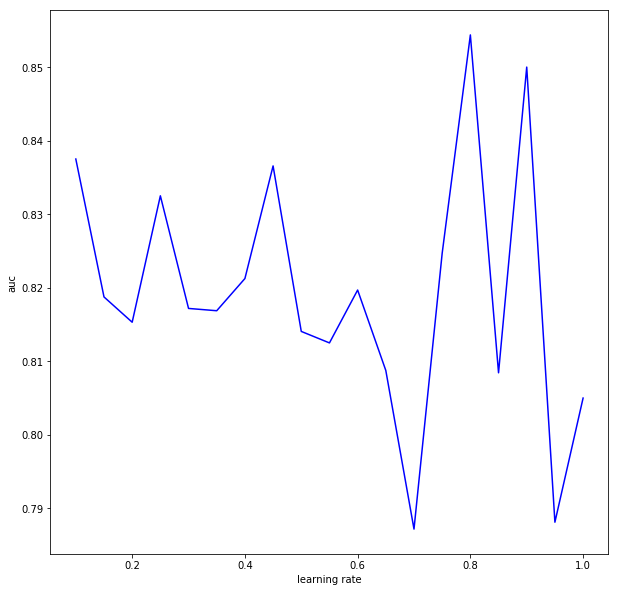

In [453]:
learning_rates = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
score_results = []

for eta in learning_rates:
    model = GradientBoostingClassifier(learning_rate=eta)
    table = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(train_features_interactions, train_labels["heart_disease_present"], test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        table.append(roc_auc)
    score_results.append(np.mean(table))
    
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(learning_rates, score_results, 'b', label="test score")
plt.ylabel('auc')
plt.xlabel('learning rate')
plt.show()

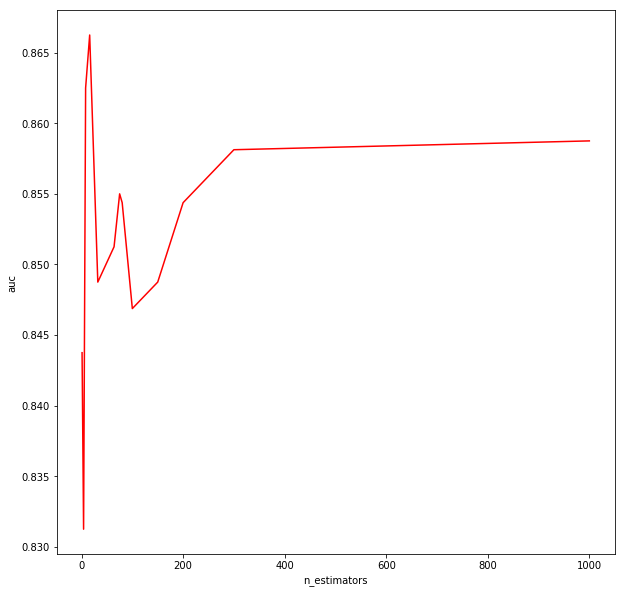

In [456]:
n_estimators = [1, 4, 8, 16, 32, 64, 75, 80, 100, 150, 200, 300, 1000]
test_results = []

for estimator in n_estimators:
    model = GradientBoostingClassifier(learning_rate=0.8, n_estimators=estimator)
    table = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(train_features_interactions, train_labels["heart_disease_present"], test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        table.append(roc_auc)
    test_results.append(np.mean(table))
    
from matplotlib.legend_handler import HandlerLine2D
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.ylabel('auc')
plt.xlabel('n_estimators')
plt.show()

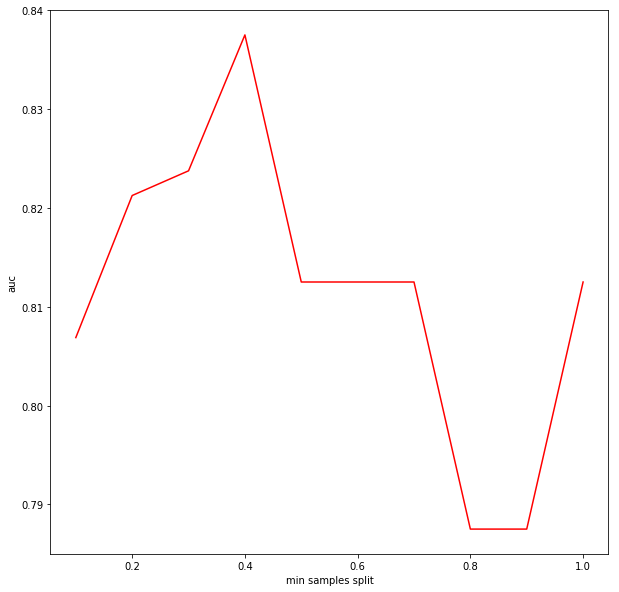

In [459]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
test_results = []

for min_samples_split in min_samples_splits:
    model = GradientBoostingClassifier(learning_rate=0.8, n_estimators=300, min_samples_split=min_samples_split)
    table = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(train_features_interactions, train_labels["heart_disease_present"], test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        table.append(roc_auc)
    test_results.append(np.mean(table))
    
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.ylabel('auc')
plt.xlabel('min samples split')
plt.show()

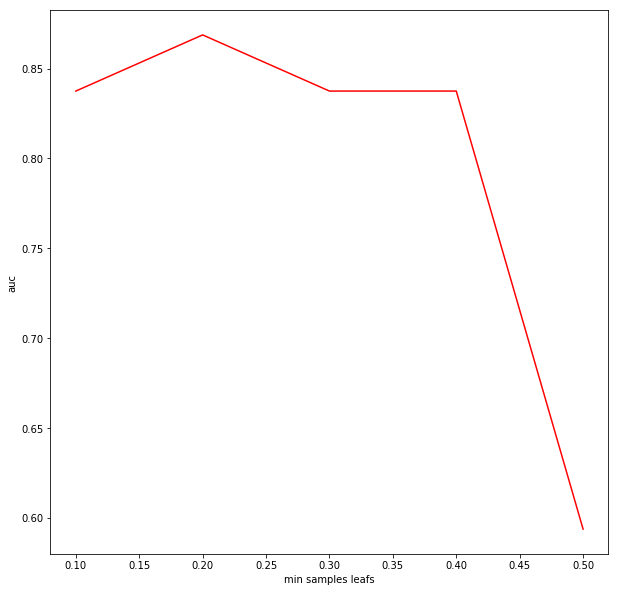

In [464]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
test_results = []
for min_samples_leaf in min_samples_leafs:
    model = GradientBoostingClassifier(learning_rate=0.4, n_estimators=300, min_samples_split=0.4, min_samples_leaf=min_samples_leaf)
    table = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(train_features_interactions, train_labels["heart_disease_present"], test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        table.append(roc_auc)
    test_results.append(np.mean(table))
    
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('auc')
plt.xlabel('min samples leafs')
plt.show()

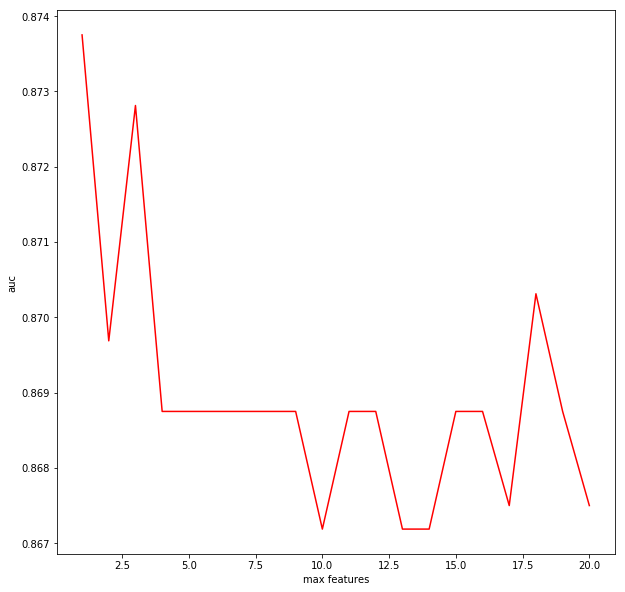

In [466]:
max_features = list(range(1,train_features_interactions.shape[1]))
test_results = []

for max_feature in max_features:
    model = GradientBoostingClassifier(learning_rate=0.4, n_estimators=300, min_samples_split=0.4, min_samples_leaf=0.2, max_features=max_feature)
    table = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(train_features_interactions, train_labels["heart_disease_present"], test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        table.append(roc_auc)
    test_results.append(np.mean(table))
    
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('auc')
plt.xlabel('max features')
plt.show()

In [500]:
# tuned gradient boosted consistently outperforms prior models
rel = []
for i in range(20):
    model_interaction = GradientBoostingClassifier(learning_rate=0.4, n_estimators=300, min_samples_split=0.4, min_samples_leaf=0.2, max_features=18)
    model_interaction.fit(train_features_interactions, train_labels["heart_disease_present"])
    scores = cross_val_score(model_interaction, train_features_interactions, train_labels["heart_disease_present"], cv=10)
    rel.append(scores.mean())
np.mean(rel)

0.8430555555555557

In [494]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 3, 5, 7, 10]
min_samples_leaf = [1, 2, 4, 8, 16]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(train_features_interactions, train_labels["heart_disease_present"])

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 3, 5, 7, 10], 'min_samples_leaf': [1, 2, 4, 8, 16]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [495]:
rf_random.best_params_

{'n_estimators': 522,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80}

In [499]:
interaction_params = {'n_estimators': 522,
                     'min_samples_split': 5,
                     'min_samples_leaf': 1,
                     'max_features': 'sqrt',
                     'max_depth': 80}

rf_reg_s = RandomForestClassifier(**interaction_params)
scores = cross_val_score(rf_reg_s, train_features_interactions, train_labels["heart_disease_present"], cv=10)
scores.mean()

0.8444444444444444

In [502]:
param_grid = {
    'max_depth': [74, 76, 80, 82],
    'max_features': [1,2,3],
    'min_samples_leaf': [1],
    'min_samples_split': [5],
    'n_estimators': [350, 400, 500, 550, 600, 650]
}

rf_gs = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf_gs, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(train_features_interactions, train_labels["heart_disease_present"])
grid_search.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   58.3s finished
c:\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 74,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 500}

In [505]:
interaction_gs_params = {'max_depth': 74,
                         'max_features': 2,
                         'min_samples_leaf': 1,
                         'min_samples_split': 5,
                         'n_estimators': 500}

rf_reg_s = RandomForestClassifier(**interaction_gs_params)
scores = cross_val_score(rf_reg_s, train_features_interactions, train_labels["heart_disease_present"], cv=10)
scores.mean()

0.85

In [515]:
rf_interactions_tuned = RandomForestRegressor(**interaction_gs_params)
rf_interactions_tuned.fit(train_features_interactions, train_labels["heart_disease_present"]) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=74,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [508]:
# we will have to prepare the test data as well with the interaction terms chosen
len(test_values.columns)

14

In [509]:
len(train_features_interactions.columns)

21

In [510]:
# test_values needs to be one hot encoded and then have interaction terms added
test_values_interactions = one_hot_encode(test_values.drop('patient_id',axis=1), 'thal')
test_values_interactions["slope_of_peak_exercise_st_segment+chest_pain_type+reversible_defect"] = test_values_interactions["slope_of_peak_exercise_st_segment"] * test_values_interactions["chest_pain_type"] * test_values_interactions["reversible_defect"]  
test_values_interactions["max_heart_rate_achieved+normal"] = test_values_interactions["max_heart_rate_achieved"] * test_values_interactions["normal"]
test_values_interactions["slope_of_peak_exercise_st_segment+chest_pain_type+num_major_vessels"] = test_values_interactions["slope_of_peak_exercise_st_segment"] * test_values_interactions["chest_pain_type"] * test_values_interactions["num_major_vessels"]
test_values_interactions["chest_pain_type+oldpeak_eq_st_depression+reversible_defect"] = test_values_interactions["chest_pain_type"] * test_values_interactions["oldpeak_eq_st_depression"] * test_values_interactions["reversible_defect"]
test_values_interactions["chest_pain_type+oldpeak_eq_st_depression+exercise_induced_angina"] = test_values_interactions["chest_pain_type"] * test_values_interactions["oldpeak_eq_st_depression"] * test_values_interactions["exercise_induced_angina"]
test_values_interactions["resting_blood_pressure+chest_pain_type+reversible_defect"] = test_values_interactions["resting_blood_pressure"] * test_values_interactions["chest_pain_type"] * test_values_interactions["reversible_defect"]
len(test_values_interactions.columns)

21

In [516]:
rf_interactions_predictions = rf_interactions_tuned.predict(test_values_interactions)

In [517]:
rf_interactions_predictions

array([0.38878716, 0.38389921, 0.77544683, 0.40732323, 0.87892381,
       0.30475238, 0.52599971, 0.64584986, 0.49348175, 0.44717388,
       0.48105722, 0.61958261, 0.48568492, 0.73715859, 0.44180642,
       0.31453896, 0.31423571, 0.45329524, 0.72310087, 0.36248975,
       0.87757143, 0.38676587, 0.42426537, 0.38341674, 0.44966479,
       0.7083127 , 0.42787287, 0.43676595, 0.77147222, 0.29961905,
       0.75404921, 0.3774197 , 0.49161414, 0.55300563, 0.46039921,
       0.34272778, 0.48895317, 0.57903319, 0.35892193, 0.43262128,
       0.85918571, 0.20529827, 0.7527842 , 0.43528001, 0.81188333,
       0.36514372, 0.37406746, 0.54251349, 0.46963095, 0.71624899,
       0.73566732, 0.34960635, 0.85291587, 0.45486595, 0.38849531,
       0.37769206, 0.82290447, 0.50522561, 0.56122619, 0.56686335,
       0.37856905, 0.72934827, 0.46287684, 0.89691667, 0.50246277,
       0.83026732, 0.82725238, 0.54843268, 0.69493571, 0.67977684,
       0.41409524, 0.87901429, 0.87044524, 0.85359206, 0.74974

In [513]:
df_out = test_values[['patient_id']]
df_out['heart_disease_present'] = rf_interactions_predictions
df_out.to_csv("rf_interactions_predictions.csv", index=False)

c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [526]:
clf = AdaBoostRegressor(n_estimators=1000, learning_rate=0.00266)
clf.fit(train_features_interactions, train_labels["heart_disease_present"])
adaboost_interactions_predictions = clf.predict(test_values_interactions)

In [527]:
adaboost_interactions_predictions

array([0.25      , 0.60869565, 1.        , 0.42857143, 0.97826087,
       0.46428571, 0.66666667, 0.7       , 0.80769231, 0.8       ,
       0.8       , 0.91836735, 0.8       , 0.95238095, 0.75609756,
       0.48      , 0.33333333, 0.55555556, 0.92857143, 0.69642857,
       1.        , 0.74418605, 0.78571429, 0.61764706, 0.15306122,
       1.        , 0.14285714, 0.74      , 0.91666667, 0.47826087,
       1.        , 0.16455696, 0.38709677, 0.83333333, 0.77272727,
       0.5       , 0.59183673, 0.90909091, 0.15      , 0.625     ,
       1.        , 0.12844037, 0.94      , 0.8       , 1.        ,
       0.78571429, 0.74074074, 0.82857143, 0.84375   , 0.91666667,
       0.96721311, 0.78125   , 1.        , 0.80645161, 0.15384615,
       0.77777778, 1.        , 0.82352941, 0.95454545, 1.        ,
       0.66666667, 0.91071429, 0.8       , 0.97674419, 0.8125    ,
       0.97674419, 0.97674419, 0.42424242, 1.        , 0.78571429,
       0.6       , 1.        , 1.        , 1.        , 0.94230

In [523]:
df_out = test_values[['patient_id']]
df_out['heart_disease_present'] = adaboost_interactions_predictions
df_out.to_csv("adaboost_interactions_predictions.csv", index=False)

c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [529]:
glf_predictions_multigen = []
for i in range(100):
    glf = GradientBoostingRegressor(learning_rate=0.4, n_estimators=300, min_samples_split=0.4, min_samples_leaf=0.2, max_features=18)
    glf.fit(train_features_interactions, train_labels["heart_disease_present"])
    glf_predictions = glf.predict(test_values_interactions)
    glf_predictions = abs(glf_predictions)
    glf_predictions_multigen.append(glf_predictions)
    
glf_predictions_multigen = np.mean(glf_predictions_multigen, axis=0)

In [530]:
glf_predictions_multigen

array([0.40192716, 0.91222389, 0.56109153, 0.30147266, 1.42200677,
       0.49837913, 0.37475458, 0.41243186, 1.28912062, 0.90179617,
       0.58881627, 0.56797022, 0.54676068, 0.25786171, 0.63129131,
       0.4719016 , 0.68676942, 0.48998371, 0.5089173 , 0.54375226,
       1.00748695, 0.08557388, 0.83446925, 0.55252406, 0.55021625,
       0.64467574, 0.49843227, 0.39796903, 0.69115837, 0.5589346 ,
       0.59728819, 0.08529826, 0.62438671, 0.60651778, 0.96861295,
       0.58561377, 0.13162039, 0.62560644, 0.43835911, 0.8040012 ,
       0.80802014, 0.06403643, 0.63885434, 0.90729259, 0.62959087,
       0.5417786 , 0.53489392, 0.61247034, 0.5063834 , 0.93995488,
       1.017722  , 0.21930377, 0.84134403, 1.07475111, 0.21408456,
       0.61772409, 0.89392886, 0.87100049, 1.03736842, 0.50682446,
       0.14601771, 0.83527714, 0.90027971, 0.8017726 , 0.80849884,
       1.09927053, 0.84639506, 0.38826774, 0.56539272, 0.74357009,
       0.70840431, 0.70916765, 0.9375843 , 0.72209817, 0.51321

In [531]:
df_out = test_values[['patient_id']]
df_out['heart_disease_present'] = glf_predictions_multigen
df_out.to_csv("glf_tuned_predictions_multigen.csv", index=False)

c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [534]:
train_features_interactions.describe()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,...,exercise_induced_angina,fixed_defect,normal,reversible_defect,max_heart_rate_achieved+normal,slope_of_peak_exercise_st_segment+chest_pain_type+num_major_vessels,slope_of_peak_exercise_st_segment+chest_pain_type+reversible_defect,resting_blood_pressure+chest_pain_type+reversible_defect,chest_pain_type+oldpeak_eq_st_depression+exercise_induced_angina,chest_pain_type+oldpeak_eq_st_depression+reversible_defect
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,...,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,1.550000,131.311111,3.155556,0.694444,0.161111,1.050000,249.211111,1.010000,0.688889,54.811111,...,0.316667,0.044444,0.544444,0.411111,84.355556,3.994444,2.494444,190.688889,1.625556,2.031667
std,0.618838,17.010443,0.938454,0.969347,0.368659,0.998742,52.717969,1.121357,0.464239,9.334737,...,0.466474,0.206655,0.499410,0.493408,78.971646,6.704036,3.487403,243.598587,3.629798,4.011220
min,1.000000,94.000000,1.000000,0.000000,0.000000,0.000000,126.000000,0.000000,0.000000,29.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,120.000000,3.000000,0.000000,0.000000,0.000000,213.750000,0.000000,0.000000,48.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,130.000000,3.000000,0.000000,0.000000,2.000000,245.500000,0.800000,1.000000,55.000000,...,0.000000,0.000000,1.000000,0.000000,122.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,140.000000,4.000000,1.000000,0.000000,2.000000,281.250000,1.600000,1.000000,62.000000,...,1.000000,0.000000,1.000000,1.000000,161.250000,6.000000,4.000000,474.000000,0.400000,3.050000
max,3.000000,180.000000,4.000000,3.000000,1.000000,2.000000,564.000000,6.200000,1.000000,77.000000,...,1.000000,1.000000,1.000000,1.000000,202.000000,36.000000,12.000000,712.000000,22.400000,24.800000


In [535]:
test_values_interactions.describe()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,...,exercise_induced_angina,fixed_defect,normal,reversible_defect,slope_of_peak_exercise_st_segment+chest_pain_type+reversible_defect,max_heart_rate_achieved+normal,slope_of_peak_exercise_st_segment+chest_pain_type+num_major_vessels,chest_pain_type+oldpeak_eq_st_depression+reversible_defect,chest_pain_type+oldpeak_eq_st_depression+exercise_induced_angina,resting_blood_pressure+chest_pain_type+reversible_defect
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,...,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,1.655556,131.411111,3.211111,0.622222,0.122222,0.966667,250.555556,1.130000,0.655556,53.677778,...,0.355556,0.066667,0.600000,0.333333,2.166667,93.100000,4.033333,2.105556,2.261111,157.788889
std,0.602637,19.552806,0.977206,0.894148,0.329377,0.999438,49.835936,1.193847,0.477849,8.641197,...,0.481363,0.250841,0.492642,0.474045,3.389508,78.621273,6.589829,4.111982,4.212280,238.348555
min,1.000000,94.000000,1.000000,0.000000,0.000000,0.000000,166.000000,0.000000,0.000000,34.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,120.000000,3.000000,0.000000,0.000000,0.000000,212.250000,0.000000,0.000000,46.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,130.000000,4.000000,0.000000,0.000000,0.000000,243.500000,0.800000,1.000000,54.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,141.500000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,140.000000,4.000000,1.000000,0.000000,2.000000,274.750000,1.875000,1.000000,60.000000,...,1.000000,0.000000,1.000000,1.000000,4.000000,162.500000,8.000000,1.800000,3.300000,397.500000
max,3.000000,200.000000,4.000000,3.000000,1.000000,2.000000,409.000000,4.000000,1.000000,76.000000,...,1.000000,1.000000,1.000000,1.000000,12.000000,187.000000,24.000000,16.000000,16.000000,800.000000


# OVERSAMPLING

In [20]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
columns = train_features.columns
train_features_over,train_labels_over=os.fit_sample(train_features, train_labels["heart_disease_present"])
train_features_over = pd.DataFrame(data=train_features_over,columns=columns)
train_labels_over = pd.DataFrame(data=train_labels_over,columns=['heart_disease_present'])

In [21]:
print("length of oversampled data is ",len(train_features_over))
print("Number of no subscription in oversampled data",len(train_labels_over[train_labels_over['heart_disease_present']==0]))
print("Number of subscription",len(train_labels_over[train_labels_over['heart_disease_present']==1]))
print("Proportion of no subscription data in oversampled data is ",len(train_labels_over[train_labels_over['heart_disease_present']==0])/len(train_features_over))
print("Proportion of subscription data in oversampled data is ",len(train_labels_over[train_labels_over['heart_disease_present']==1])/len(train_features_over))

length of oversampled data is  200
Number of no subscription in oversampled data 100
Number of subscription 100
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


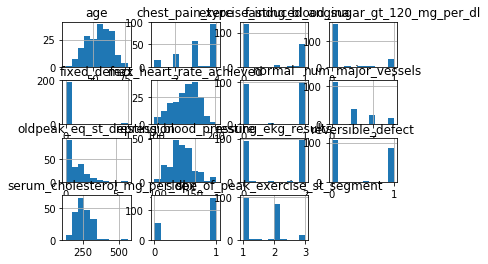

In [22]:
train_features_over.hist();

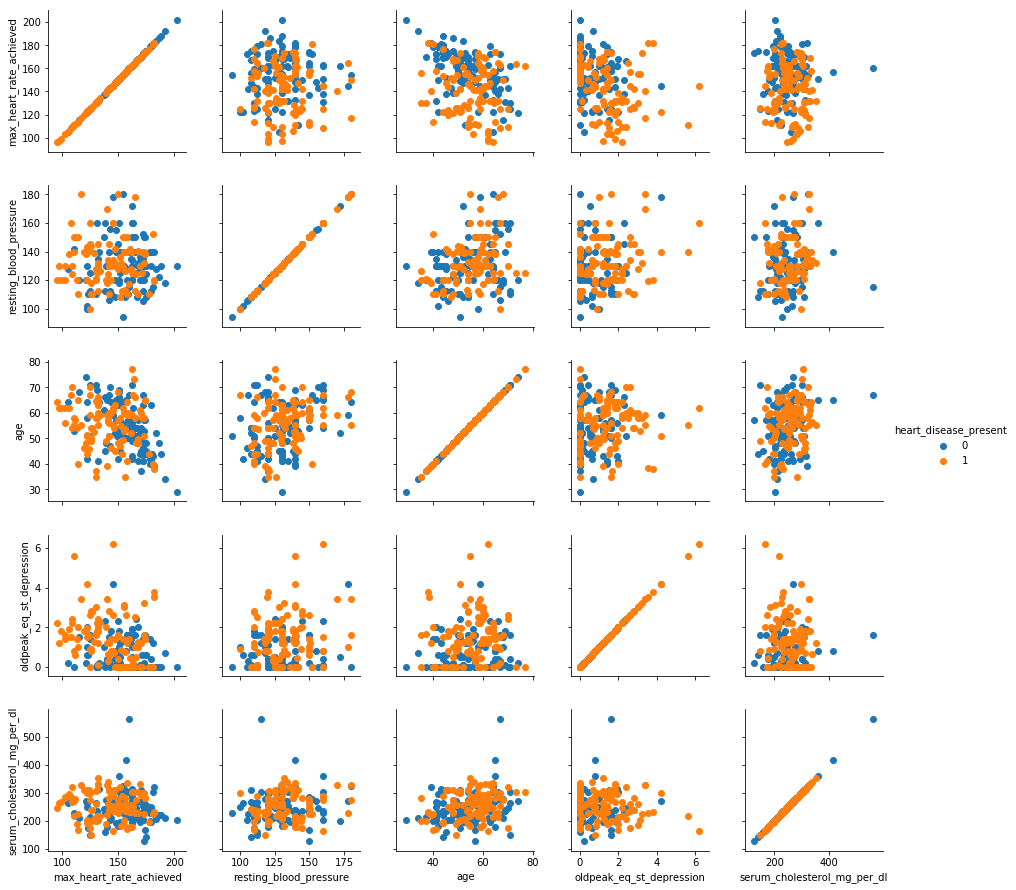

In [566]:
train_with_labels = train_features_over
train_with_labels["heart_disease_present"] = train_labels_over["heart_disease_present"] 
g = sns.PairGrid(train_with_labels, hue="heart_disease_present", vars=["max_heart_rate_achieved", "resting_blood_pressure", "age", "oldpeak_eq_st_depression", "serum_cholesterol_mg_per_dl"])
g.map(plt.scatter);
g.add_legend();

In [553]:
rf_reg_s = RandomForestClassifier(**best_params_small)
scores = cross_val_score(rf_reg_s, train_features_over, train_labels_over, cv=10)
scores.mean()

c:\python37\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\python37\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\python37\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\python37\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

0.8400000000000001

In [555]:
rf_overs = RandomForestRegressor(**best_params_small)
rf_overs.fit(train_features_over, train_labels_over)
rf_overs_predictions = rf_overs.predict(one_hot_encode(test_values.drop('patient_id',axis=1), 'thal'))
rf_overs_predictions

c:\python37\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


array([0.44046265, 0.1691229 , 0.93239129, 0.25367565, 0.77069897,
       0.02141868, 0.37397429, 0.73769842, 0.28569617, 0.13778794,
       0.24617913, 0.62728306, 0.2899921 , 0.86148526, 0.19733023,
       0.05521478, 0.07241855, 0.23426294, 0.82774701, 0.05178699,
       0.96577449, 0.14178616, 0.16951877, 0.12352177, 0.54181985,
       0.84588833, 0.54014666, 0.25302522, 0.52916116, 0.02320093,
       0.89720167, 0.47633526, 0.58768799, 0.3105788 , 0.29582629,
       0.12703221, 0.34006703, 0.26314321, 0.30065365, 0.16979975,
       0.93206209, 0.23416797, 0.9070045 , 0.11906624, 0.86288732,
       0.06103325, 0.12837839, 0.3271202 , 0.21123572, 0.54624374,
       0.46270161, 0.06800699, 0.92867551, 0.19706357, 0.43533659,
       0.06442902, 0.80554213, 0.16944308, 0.18881692, 0.64402293,
       0.11166954, 0.90090302, 0.19960928, 0.76037852, 0.21467605,
       0.67312945, 0.62806621, 0.55926973, 0.86622907, 0.60377739,
       0.19776841, 0.95899251, 0.94792182, 0.92564314, 0.89276

In [556]:
df_out = test_values[['patient_id']]
df_out['heart_disease_present'] = rf_overs_predictions
df_out.to_csv("rf_overs_predictions.csv", index=False)

c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [84]:
last_params = {'max_depth': 10,
             'max_features': 'auto',
             'min_samples_leaf': 7,
             'min_samples_split': 2,
             'n_estimators': 1400,
             'oob_score': True}

rf_overs = RandomForestRegressor(**last_params)
rf_overs.fit(train_features_over, train_labels_over)
rf_overs_predictions = rf_overs.predict(one_hot_encode(test_values.drop('patient_id',axis=1), 'thal'))
rf_overs_predictions

c:\python37\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


array([0.46492613, 0.12997885, 0.96669944, 0.26824805, 0.70459805,
       0.0095678 , 0.27482067, 0.74037793, 0.26242571, 0.0950306 ,
       0.14131734, 0.62412265, 0.23496966, 0.93193011, 0.22243753,
       0.07632248, 0.06408659, 0.23096597, 0.78443317, 0.0174269 ,
       0.99269605, 0.13325386, 0.19155886, 0.12834075, 0.55913319,
       0.82937185, 0.509175  , 0.20395342, 0.52296878, 0.00980534,
       0.97689833, 0.48614662, 0.67844675, 0.19615811, 0.31551614,
       0.10524111, 0.28884042, 0.21358165, 0.29963779, 0.15643374,
       0.99192541, 0.2046342 , 0.94344943, 0.04195982, 0.93432135,
       0.02641091, 0.11169109, 0.33019177, 0.21672532, 0.51068729,
       0.37341153, 0.07795115, 0.98599331, 0.21414802, 0.42641361,
       0.04908252, 0.76946069, 0.19103299, 0.1315546 , 0.62414213,
       0.10955543, 0.92842632, 0.15671262, 0.69559052, 0.24167307,
       0.63293107, 0.56200631, 0.61620344, 0.95343219, 0.54243012,
       0.17347218, 0.98655021, 0.98139732, 0.970957  , 0.94883

In [576]:
df_out = test_values[['patient_id']]
df_out['heart_disease_present'] = rf_overs_predictions
df_out.to_csv("rf_last_tuned_overs_predictions.csv", index=False)

c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [568]:
param_grid = {
    'max_depth': [10, 20, 30, 60, 70, 80],
    'max_features': ["auto"],
    'min_samples_leaf': [4, 6, 8, 10],
    'min_samples_split': [2, 3],
    'n_estimators': [1400, 1500, 1600, 1650]
}

rf_gs = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf_gs, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(train_features_over, train_labels_over)
grid_search.best_params_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 15.0min finished
c:\python37\lib\site-packages\sklearn\model_selection\_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1400}

In [572]:
gs_over_params = {'max_depth': 10,
                 'max_features': 'auto',
                 'min_samples_leaf': 4,
                 'min_samples_split': 2,
                 'n_estimators': 1400}

rf_overs = RandomForestRegressor(**gs_over_params)
rf_overs.fit(train_features_over.drop("heart_disease_present", axis=1), train_labels_over)
rf_overs_predictions = rf_overs.predict(one_hot_encode(test_values.drop('patient_id',axis=1), 'thal'))
rf_overs_predictions

c:\python37\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


array([0.37349211, 0.12160563, 0.98560627, 0.31443195, 0.77510095,
       0.00444813, 0.39144025, 0.73169853, 0.2498623 , 0.07172425,
       0.2352919 , 0.65486179, 0.22338077, 0.95162889, 0.17746606,
       0.03569396, 0.10632862, 0.30026798, 0.85667177, 0.01283148,
       0.9943869 , 0.08338787, 0.15561863, 0.1551558 , 0.60410014,
       0.86703652, 0.56497358, 0.18603901, 0.49470237, 0.00485289,
       0.98419926, 0.41124362, 0.69598841, 0.26948313, 0.30295324,
       0.09364859, 0.29347618, 0.22773367, 0.25616881, 0.18545516,
       0.98895351, 0.17493798, 0.94038816, 0.07422903, 0.92498253,
       0.01190221, 0.07646705, 0.37674157, 0.16318302, 0.56025789,
       0.42631582, 0.03436352, 0.97921627, 0.18801634, 0.36793742,
       0.02461173, 0.80632794, 0.17008462, 0.14045481, 0.60865883,
       0.17410349, 0.92952626, 0.13346032, 0.77419729, 0.20058934,
       0.70380609, 0.57086923, 0.56635184, 0.96612809, 0.63805505,
       0.16607484, 0.96842185, 0.96394707, 0.93615147, 0.95760

In [573]:
df_out = test_values[['patient_id']]
df_out['heart_disease_present'] = rf_overs_predictions
df_out.to_csv("rf_tuned_overs_predictions.csv", index=False)

c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# GRIDSEARCHING XGB IMPLEMENTATION

In [67]:
import xgboost as xgba
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgb = xgba.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

#random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(train_features_over.drop("heart_disease_present", axis=1),train_labels_over), verbose=3, random_state=1001 )
#random_search.fit(train_features_over ,train_labels_over)
#print('\n Best hyperparameters:')
#print(random_search.best_params_)

In [71]:
xgb_t = xgba.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1, subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8)
xgb_t.fit(X_train, y_train)
scores = cross_val_score(xgb_t, train_features_over, train_labels_over, cv=10);
scores.mean()

c:\python37\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\python37\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\python37\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\python37\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

0.8400000000000001

In [76]:
xgb_r = xgba.XGBRegressor(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1, subsample=0.6, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=0.8)
xgb_r.fit(train_features_over, train_labels_over)
xgb_r_predictions = xgb_r.predict(one_hot_encode(test_values.drop('patient_id',axis=1), 'thal'))

In [596]:
xgb_r_predictions

array([0.4575645 , 0.07489076, 0.9758858 , 0.2501092 , 0.97080773,
       0.01403728, 0.07462809, 0.8717841 , 0.436138  , 0.0924701 ,
       0.17164618, 0.5827564 , 0.17458667, 0.96777457, 0.12134325,
       0.02768394, 0.02349424, 0.09106266, 0.93580776, 0.01746746,
       0.9911699 , 0.03500845, 0.07554147, 0.04467509, 0.58257145,
       0.96316427, 0.5698919 , 0.10178476, 0.59752846, 0.01627997,
       0.9633072 , 0.3395342 , 0.8344814 , 0.20956776, 0.37096363,
       0.04736387, 0.27392125, 0.13345148, 0.3346835 , 0.13467667,
       0.980907  , 0.03961862, 0.9701459 , 0.03835695, 0.9789491 ,
       0.04243038, 0.03458891, 0.29748482, 0.19904654, 0.8668697 ,
       0.7299805 , 0.02124286, 0.9849258 , 0.15092926, 0.39315948,
       0.02699051, 0.8822063 , 0.07572781, 0.06750451, 0.7808524 ,
       0.04253372, 0.96929014, 0.20438416, 0.9478353 , 0.14448093,
       0.9187544 , 0.8493883 , 0.7204223 , 0.9348227 , 0.64235234,
       0.03445021, 0.97836167, 0.9817047 , 0.9815207 , 0.98475

In [597]:
df_out = test_values[['patient_id']]
df_out['heart_disease_present'] = xgb_r_predictions
df_out.to_csv("xgb_r_predictions.csv", index=False)

c:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# AUTOML

In [46]:
from tpot import TPOTClassifier, TPOTRegressor

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train_features_over, train_labels_over, test_size=0.33, random_state=42)
tpot = TPOTClassifier(verbosity=2, n_jobs=-1)
tpot.fit(X_train, y_train)

c:\python37\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Generation 1 - Current best internal CV score: 0.8734432234432233
Generation 2 - Current best internal CV score: 0.8734432234432233
Generation 3 - Current best internal CV score: 0.8734432234432233
Generation 4 - Current best internal CV score: 0.8734432234432233
Generation 5 - Current best internal CV score: 0.8734432234432233
Generation 6 - Current best internal CV score: 0.8734432234432233
Generation 7 - Current best internal CV score: 0.8734432234432233
Generation 8 - Current best internal CV score: 0.8734432234432233
Generation 9 - Current best internal CV score: 0.8803215303215304
Generation 10 - Current best internal CV score: 0.8803215303215304
Generation 11 - Current best internal CV score: 0.8803215303215304
Generation 12 - Current best internal CV score: 0.8803215303215304
Generation 13 - Current best internal CV score: 0.8811355311355312
Generation 14 - Current best internal CV score: 0.8882783882783883
Generation 15 - Current best internal CV score: 0.8882783882783883
Gene

TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
        disable_update_check=False, early_stop=None, generations=100,
        max_eval_time_mins=5, max_time_mins=None, memory=None,
        mutation_rate=0.9, n_jobs=-1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=100,
        random_state=None, scoring=None, subsample=1.0,
        template='RandomTree', use_dask=False, verbosity=2,
        warm_start=False)

In [30]:
# with default parameters, tpot will evaluate about 10k pipelines before exiting
# we can see what model tpot decides we should go with and tune that more carefully

print('Best pipeline test accuracy: %.3f' % tpot.score(X_test, y_test))
tpot.export('tpot_exported_pipeline.py')

c:\python37\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best pipeline test accuracy: 0.833


In [51]:
# TPOT generated code modded to be regressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

tpot_pipeline = make_pipeline(
    RobustScaler(),
    GradientBoostingClassifier(learning_rate=0.1, max_depth=8, max_features=0.1, min_samples_leaf=4, min_samples_split=3, n_estimators=100, subsample=0.35000000000000003)
)

In [52]:
tpot_pipeline.fit(train_features_over, train_labels_over)

c:\python37\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('gradientboostingclassifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              ma...35000000000000003, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False))])

In [56]:
out = tpot_pipeline.predict_proba(one_hot_encode(test_values.drop('patient_id',axis=1), 'thal'))
out = [x[1] for x in out]
out

[0.6974505168089591,
 0.018389085379928623,
 0.9762241415485683,
 0.11176434356315526,
 0.9859272196434943,
 0.004028131665876331,
 0.20778924989188313,
 0.9766585182357379,
 0.4670094841589412,
 0.1827993251833324,
 0.10227982445952553,
 0.7628548353423539,
 0.2486978471195666,
 0.9918486222645371,
 0.13734731911768072,
 0.013385071854695398,
 0.011788006701929409,
 0.050856531711726695,
 0.9712420217208951,
 0.016260296501703676,
 0.9943361994354566,
 0.019465206226872964,
 0.05176048182263096,
 0.016513511614032337,
 0.2942065979780507,
 0.9612177595568866,
 0.5418671857758545,
 0.16915019360100467,
 0.5370387379799778,
 0.00498685691396712,
 0.9844908836835107,
 0.5101526561225691,
 0.9091717728795398,
 0.29126096966527554,
 0.21556863594889247,
 0.006870285766208401,
 0.2733157250182894,
 0.09330699458761867,
 0.05850439763926468,
 0.12013042387720943,
 0.9981332797297381,
 0.03479807659343979,
 0.9247587995639371,
 0.04382150688867959,
 0.873599419244081,
 0.004145908317148484,
 

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(out.reshape(-1, 1))
scaledout = (scaler.transform(out.reshape(-1, 1)))
broughtout = [x[0] for x in scaledout]
broughtout

[0.41864623712510823,
 0.32902137258555386,
 0.8129549358917576,
 0.216444967528518,
 0.7221062147615394,
 0.0,
 0.04071995082343419,
 0.5118266810904589,
 0.5490244886556929,
 0.31103814032529764,
 0.2884165163730884,
 0.6176050454930793,
 0.29949165621209156,
 0.828737992887572,
 0.1704736095266664,
 0.07555742616146871,
 0.13046751633387962,
 0.18556713180605813,
 0.7615021802917619,
 0.09641710490756192,
 0.8800044509437364,
 0.11308797639201164,
 0.25515930472523807,
 0.09903806076927427,
 0.594931222897906,
 0.6898927701169406,
 0.5040895217227386,
 0.325891913250542,
 0.450740731165313,
 0.055020712461587545,
 0.8234286981093364,
 0.4806095744579111,
 0.4608005753150073,
 0.3578735404730391,
 0.3769696033848701,
 0.2575341294526631,
 0.45284208689758265,
 0.1958971060982418,
 0.3238929279851258,
 0.31641499045935517,
 0.789460062101683,
 0.1884884616222238,
 0.8179157958854177,
 0.2009408393480886,
 0.6811345939849425,
 0.21542797730337743,
 0.10542950046602885,
 0.2238955991304

In [80]:
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV

def ll_model(model, rmode = False):
    sig_clf = CalibratedClassifierCV(model, method="sigmoid", cv="prefit")
    sig_clf.fit(X_train, y_train)
    if not rmode:
        sig_clf_probs = sig_clf.predict_proba(X_test)
        sig_score = log_loss(y_test, sig_clf_probs)
        return sig_score
    else:
        sig_clf_probs = sig_clf.predict(X_test)
        sig_score = log_loss(y_test, sig_clf_probs)
        return sig_score
    
def ll_model_proba(model, rmode = False):
    sig_clf = CalibratedClassifierCV(model, method="sigmoid", cv="prefit")
    sig_clf.fit(X_train, y_train)
    if not rmode:
        sig_clf_probs = sig_clf.predict_proba(X_test)
        sig_score = log_loss(y_test, sig_clf_probs)
        return sig_score
    else:
        sig_clf_probs = sig_clf.predict(X_test)
        sig_score = log_loss(y_test, sig_clf_probs)
        return sig_score

In [86]:
gs_over_params = {'max_depth': 10,
                 'max_features': 'auto',
                 'min_samples_leaf': 4,
                 'min_samples_split': 2,
                 'n_estimators': 1400}

rf_overs = RandomForestClassifier(**gs_over_params)
rf_overs.fit(X_train, y_train)
ll_model(rf_overs)

c:\python37\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
c:\python37\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.41457006183827194

In [87]:
gs1_params = {'max_depth': 10,
             'max_features': 'auto',
             'min_samples_leaf': 7,
             'min_samples_split': 2,
             'n_estimators': 1400,
             'oob_score': True}

rf_gs_scorer = RandomForestClassifier(**gs1_params)
rf_gs_scorer.fit(X_train, y_train)
ll_model(rf_gs_scorer)

c:\python37\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
c:\python37\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.39088851216599374

In [89]:
ll_model(tpot_pipeline)

c:\python37\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.11537998254911275